In [2]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

# %load_ext autoreload
# %autoreload 2

In [3]:
data = np.load("embedded_data_vae_nokl.npz")

In [4]:
data.files
print(data['x_test_e'].shape)

(39232, 31)


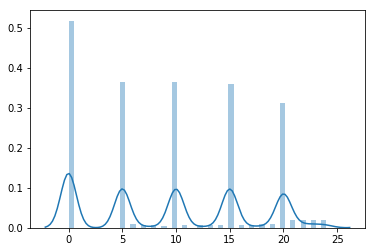

In [5]:
sns.distplot(data['x_train'][:,46:47])

In [6]:

final_df_train = pd.read_csv('train_state_action_reward_df.csv')
final_df_test = pd.read_csv('test_state_action_reward_df.csv')
print(final_df_test.shape)

(39232, 56)


In [7]:
final_df_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
       'interval_end_time', 'ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive', 'discrete_action', 'hospital_expire_flag',
       'reward', 'row_id', 'row_id_next'],
      dtype='object')

In [8]:
embedding = pd.DataFrame(data['x_train_e'][:,:-1], columns=["emb_" + str(i) for i in range(30)])
embedding.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29
0,0.187401,3.958101,0.472268,-0.139773,0.735442,-0.153290,-1.194377,-1.012972,0.389961,1.357446,...,1.394558,-0.848935,0.598768,-0.550669,1.359470,-0.563808,1.229256,0.126772,-3.694055,1.459705
1,0.153618,3.999811,0.475729,-0.092441,0.775785,-0.074642,-1.080217,-0.850899,0.592073,1.402950,...,1.234463,-0.912077,0.548676,-0.673983,1.366719,-0.593577,1.258903,0.405502,-3.921488,1.204356
2,0.150906,3.723779,0.464004,-0.137541,1.006575,0.015126,-0.906126,-0.975521,0.447679,1.298515,...,1.325724,-0.995530,0.600313,-0.733013,1.350996,-0.468612,1.218910,0.510290,-3.759446,1.215971
3,0.305264,3.555363,1.017435,0.021784,1.052130,-1.036112,-1.165587,-0.202922,0.238243,2.223132,...,0.968919,-0.387632,0.735939,-0.889601,1.723265,-0.727432,0.847920,0.688438,-3.916931,0.345471
4,-0.022681,3.748852,0.727602,-0.183611,0.874978,-0.633402,-0.836109,-0.476325,0.221943,2.120401,...,0.982527,-0.187802,0.672592,-0.892616,1.680194,-0.630756,0.612514,0.361811,-4.333654,0.535367


In [9]:

def get_combined(embedded, non_embedded):
    embedding = pd.DataFrame(embedded[:,:-1], columns=["emb_" + str(i) for i in range(30)])
    first_part = non_embedded.iloc[:,:5]
    replace = non_embedded.iloc[:,5:-5]
    last_part = non_embedded.iloc[:,-5:]
    intermediate = first_part.join(embedding)
    train_x= intermediate.join(last_part)
    return train_x

final_df_test = get_combined(data['x_test_e'], final_df_test)
final_df_train = get_combined(data['x_train_e'], final_df_train)


In [10]:
final_df_train.shape

(153582, 40)

In [11]:
# add timestamps per episode
final_df_test['time_step'] =  final_df_test.groupby(['subject_id','hadm_id','icustay_id']).cumcount()+1
final_df_train['time_step'] =  final_df_train.groupby(['subject_id','hadm_id','icustay_id']).cumcount()+1

(array([1.3700e+04, 0.0000e+00, 1.3443e+04, 0.0000e+00, 0.0000e+00,
        1.3174e+04, 0.0000e+00, 1.2830e+04, 0.0000e+00, 0.0000e+00,
        1.2539e+04, 0.0000e+00, 0.0000e+00, 1.2220e+04, 0.0000e+00,
        1.1909e+04, 0.0000e+00, 0.0000e+00, 1.1409e+04, 0.0000e+00,
        0.0000e+00, 1.0659e+04, 0.0000e+00, 9.6770e+03, 0.0000e+00,
        0.0000e+00, 8.6580e+03, 0.0000e+00, 7.6900e+03, 0.0000e+00,
        0.0000e+00, 6.4720e+03, 0.0000e+00, 0.0000e+00, 3.4410e+03,
        0.0000e+00, 2.1310e+03, 0.0000e+00, 0.0000e+00, 1.5170e+03,
        0.0000e+00, 0.0000e+00, 1.1640e+03, 0.0000e+00, 9.4700e+02,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.38,  1.76,  2.14,  2.52,  2.9 ,  3.28,  3.66,  4.04,
         4.42,  4.8 ,  5.18,  5.56,  5.94,  6.32,  6.7 ,  7.08,  7.46,
         7.84,  8.22,  8.6 ,  8.98,  9.36,  9.74, 10.12, 10.5 , 10.88,
        11.26, 11.64, 12.02, 12.4 , 12.78, 13.16, 13.54, 13.92, 14.3 ,
        14.68, 15.06, 15.44, 15.82

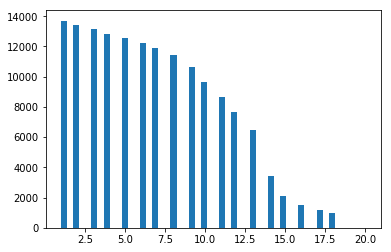

In [12]:
plt.hist(final_df_train['time_step'], bins=50)

(array([3422.,    0., 3361.,    0.,    0., 3310.,    0.,    0., 3220.,
           0.,    0., 3148.,    0.,    0., 3087.,    0.,    0., 3000.,
           0.,    0., 2900.,    0.,    0., 2728.,    0.,    0., 2497.,
           0.,    0., 2270.,    0.,    0., 2049.,    0.,    0., 1720.,
           0.,    0.,  929.,    0.,    0.,  583.,    0.,    0.,  416.,
           0.,    0.,  326.,    0.,  266.]),
 array([ 1.  ,  1.34,  1.68,  2.02,  2.36,  2.7 ,  3.04,  3.38,  3.72,
         4.06,  4.4 ,  4.74,  5.08,  5.42,  5.76,  6.1 ,  6.44,  6.78,
         7.12,  7.46,  7.8 ,  8.14,  8.48,  8.82,  9.16,  9.5 ,  9.84,
        10.18, 10.52, 10.86, 11.2 , 11.54, 11.88, 12.22, 12.56, 12.9 ,
        13.24, 13.58, 13.92, 14.26, 14.6 , 14.94, 15.28, 15.62, 15.96,
        16.3 , 16.64, 16.98, 17.32, 17.66, 18.  ]),
 <a list of 50 Patch objects>)

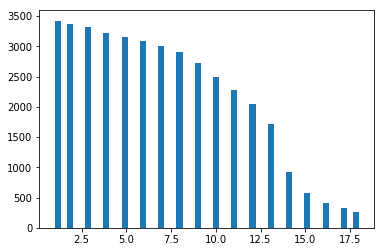

In [13]:
plt.hist(final_df_test['time_step'], bins=50)

In [14]:
# remove time steps that are 10+ steps away from end of episode
# we will only guess death based on the last 10 episodes
episode_lengths_test = final_df_test.groupby(['subject_id','hadm_id','icustay_id']).agg("count").rename(columns={"interval_start_time": "episode_length"})["episode_length"].reset_index()
episode_lengths_train = final_df_train.groupby(['subject_id','hadm_id','icustay_id']).agg("count").rename(columns={"interval_start_time": "episode_length"})["episode_length"].reset_index()

episode_rewards_test = final_df_test.groupby(['subject_id','hadm_id','icustay_id']).agg("sum").rename(columns={"reward": "total_reward"})["total_reward"].reset_index()
episode_rewards_train = final_df_train.groupby(['subject_id','hadm_id','icustay_id']).agg("sum").rename(columns={"reward": "total_reward"})["total_reward"].reset_index()



final_df_train = final_df_train.merge(episode_lengths_train, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])
final_df_test = final_df_test.merge(episode_lengths_test, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])

final_df_train = final_df_train.merge(episode_rewards_train, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])
final_df_test = final_df_test.merge(episode_rewards_test, how="outer", on=['subject_id', 'hadm_id', 'icustay_id'])



In [15]:
final_df_train['distance_from_last'] = final_df_train["episode_length"] - final_df_train["time_step"]

In [16]:
final_df_test['distance_from_last'] = final_df_test["episode_length"] - final_df_test["time_step"]

In [17]:
len(final_df_test)

39232

In [18]:
final_df_test = final_df_test[final_df_test["distance_from_last"]<10]
final_df_train = final_df_train[final_df_train["distance_from_last"]<10]

In [19]:
len(final_df_train)

121560

In [20]:
def term(df):
    if df.reward == 0:
        return "continue"
    if abs(df.reward) == 15:
        return "done"  

# remove one anomly in the data
final_df_train=final_df_train[final_df_train["total_reward"]<=15]
final_df_test=final_df_test[final_df_test["total_reward"]<=15]
labels_train = final_df_train[['reward']].apply(term, axis=1).values.reshape(-1, 1)
labels_test = final_df_test[['reward']].apply(term, axis=1).values.reshape(-1, 1)
print(labels_test.shape)
enc = OneHotEncoder()
enc.fit(labels_train)

labels_train_one_hot = enc.transform(labels_train)
labels_test_one_hot = enc.transform(labels_test)
print(labels_train_one_hot)

(30673, 1)
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 1)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (121525, 0)	1.0
  (121526, 0)	1.0
  (121527, 0)	1.0
  (121528, 0)	1.0
  (121529, 1)	1.0
  (121530, 0)	1.0
  (121531, 0)	1.0
  (121532, 0)	1.0
  (121533, 0)	1.0
  (121534, 0)	1.0
  (121535, 0)	1.0
  (121536, 0)	1.0
  (121537, 0)	1.0
  (121538, 0)	1.0
  (121539, 1)	1.0
  (121540, 0)	1.0
  (121541, 1)	1.0
  (121542, 0)	1.0
  (121543, 0)	1.0
  (121544, 0)	1.0
  (121545, 0)	1.0
  (121546, 0)	1.0
  (121547, 0)	1.0
  (121548, 0)	1.0
  (121549, 1)	1.0


In [21]:
enc.categories_

[array(['continue', 'done'], dtype=object)]

In [22]:
labels_train_one_hot.shape

(121550, 2)

In [23]:
final_df_test.shape

(30673, 44)

In [24]:
final_df_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
       'interval_end_time', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4',
       'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11',
       'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18',
       'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25',
       'emb_26', 'emb_27', 'emb_28', 'emb_29', 'discrete_action',
       'hospital_expire_flag', 'reward', 'row_id', 'row_id_next', 'time_step',
       'episode_length', 'total_reward', 'distance_from_last'],
      dtype='object')

In [25]:
max_episode = 10

features = ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4',
       'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11',
       'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18',
       'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25',
       'emb_26', 'emb_27', 'emb_28', 'emb_29', 'discrete_action' ,'time_step']
print(len(features))

def get_x_y(final_df):
    final_df_train_copy = final_df.copy()
    final_df_train_copy = final_df_train_copy.rename(columns={'row_id': 'row_id_old'})
    final_df_train_copy =  final_df_train_copy.rename(columns={'row_id_next': 'row_id'})
    key_value_train = final_df_train_copy.merge(final_df,  on=('subject_id', 'hadm_id', 'icustay_id', 'row_id'), how='left')
    train_x = key_value_train[[s + "_x" for s in features]]
    train_y = key_value_train[[s + "_y" for s in features]]
    return train_x.values, train_y.values


def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    labels_episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

32


In [26]:
final_df_train.values.shape

(121550, 44)

In [27]:
train_x, train_y = get_x_y(final_df_train)

In [28]:
test_x, test_y = get_x_y(final_df_test)

In [29]:
train_matrix = get_padded_matrix( train_x, train_y )
test_matrix = get_padded_matrix( test_x, test_y )

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 23,386
Trainable params: 23,386
Non-trainable params: 0
_________________________________________________________________


In [32]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
print(labels_test_one_hot[:])

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 1)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 1)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (30648, 0)	1.0
  (30649, 0)	1.0
  (30650, 0)	1.0
  (30651, 0)	1.0
  (30652, 1)	1.0
  (30653, 0)	1.0
  (30654, 0)	1.0
  (30655, 0)	1.0
  (30656, 0)	1.0
  (30657, 0)	1.0
  (30658, 0)	1.0
  (30659, 0)	1.0
  (30660, 0)	1.0
  (30661, 0)	1.0
  (30662, 1)	1.0
  (30663, 0)	1.0
  (30664, 0)	1.0
  (30665, 0)	1.0
  (30666, 0)	1.0
  (30667, 0)	1.0
  (30668, 0)	1.0
  (30669, 0)	1.0
  (30670, 0)	1.0
  (30671, 0)	1.0
  (30672, 1)	1.0


In [34]:
labels_test_one_hot.shape

(30673, 2)

In [35]:
 labels_train_one_hot.shape

(121550, 2)

In [36]:
early_stop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
cp_callback = tf.keras.callbacks.ModelCheckpoint("sepsis_termination_vae.model",
                                                 verbose=1, monitor='val_acc', save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/termination_vae{}".format(time()))
model.fit(train_matrix, labels_train_one_hot, epochs=10, validation_data=(test_matrix, labels_test_one_hot), callbacks=[tensorboard, cp_callback, early_stop])


Train on 121550 samples, validate on 30673 samples
Epoch 1/10
121550/121550 [==============================] - 49s 402us/step - loss: 0.1098 - acc: 0.9608 - val_loss: 0.0793 - val_acc: 0.9697

Epoch 00001: val_acc improved from -inf to 0.96968, saving model to sepsis_termination_vae.model
Epoch 2/10
121550/121550 [==============================] - 42s 349us/step - loss: 0.0835 - acc: 0.9688 - val_loss: 0.0744 - val_acc: 0.9713

Epoch 00002: val_acc improved from 0.96968 to 0.97128, saving model to sepsis_termination_vae.model
Epoch 3/10
121550/121550 [==============================] - 51s 418us/step - loss: 0.0810 - acc: 0.9690 - val_loss: 0.0714 - val_acc: 0.9717

Epoch 00003: val_acc improved from 0.97128 to 0.97170, saving model to sepsis_termination_vae.model
Epoch 4/10
121550/121550 [==============================] - 47s 389us/step - loss: 0.0797 - acc: 0.9692 - val_loss: 0.0708 - val_acc: 0.9724

Epoch 00004: val_acc improved from 0.97170 to 0.97239, saving model to sepsis_termin

In [36]:
tf.keras.models.load_model("sepsis_outcome.model")

OSError: Unable to open file (unable to open file: name = 'sepsis_outcome.model', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)